In [1]:
from tensorflow.keras.models import load_model

model = load_model("C:/Users/moksh/Downloads/word2vec_lstm_model.h5")

In [2]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [3]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 120, 200)            │       6,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d (SpatialDropout1D) │ (None, 120, 200)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 120, 256)            │         336,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 120, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,511,109 (24.84 MB)

 Trainable params: 6,510,469 (24.84 MB)

 Non-trainable params: 640 (2.50 KB)

In [4]:
import pandas as pd
df_train = pd.read_csv("C:/Users/moksh/Downloads/processed_data/processed_data/train_data.csv")
df_test = pd.read_csv("C:/Users/moksh/Downloads/processed_data/processed_data/test_data.csv")

In [5]:
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec

sentences = [tweet.split() for tweet in pd.concat([df_train, df_test])['processed_tweet']]

word2vec_model = Word2Vec(sentences, vector_size=200, window=5, min_count=1, workers=4, sg=1, epochs=20)

In [6]:
EMBEDDING_DIM = 200
LSTM_UNITS = 128
DENSE_UNITS = 64
DROPOUT_RATE = 0.3
RECURRENT_DROPOUT = 0.2
LEARNING_RATE = 0.0005
BATCH_SIZE = 256
EPOCHS = 10

In [7]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, SpatialDropout1D, Embedding, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

tokenizer = Tokenizer(num_words=30000, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['processed_tweet'])
word_index = tokenizer.word_index

embedding_matrix = np.zeros((min(30000, len(word_index))+1, 200))
for word, i in tokenizer.word_index.items():
    if i < 30000 and word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

In [8]:
X_train = pad_sequences(tokenizer.texts_to_sequences(df_train['processed_tweet']), maxlen=120, padding='post', truncating='post')
X_test = pad_sequences(tokenizer.texts_to_sequences(df_test['processed_tweet']), maxlen=120, padding='post', truncating='post')

In [9]:
le = LabelEncoder()
y_train = le.fit_transform(df_train['sentiment_label'])
y_test = le.transform(df_test['sentiment_label'])
y_train = pd.get_dummies(y_train).values
y_test = pd.get_dummies(y_test).values

In [11]:
# Save to a file
import pickle
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

In [15]:
# === Step 1: Imports ===
import numpy as np
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from lime.lime_text import LimeTextExplainer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import matplotlib.pyplot as plt

# === Step 2: Load Model, Tokenizer, and Label Encoder ===
with open("C:/Users/moksh/Downloads/tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

with open("C:/Users/moksh/Downloads/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

# === Step 3: Set Constants ===
MAX_LEN = 120  # This should match training-time sequence length
class_names = list(le.classes_)

# === Step 4: Load Your Test Data ===
texts = df_test['processed_tweet'].tolist()

# === Step 5: Define a Prediction Function for LIME ===
def predict_proba(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=MAX_LEN)
    return model.predict(padded)

# === Step 6: Run LIME on a Sample of Tweets ===
explainer = LimeTextExplainer(class_names=class_names)
word_weights = defaultdict(list)
sample_size = 100  # Use 100 random samples for global influence

for i in range(sample_size):
    text_instance = texts[i]
    exp = explainer.explain_instance(text_instance, predict_proba, num_features=10)
    
    for word, weight in exp.as_list():
        word_weights[word].append(weight)

# === Step 7: Global Word Influence Calculation ===
avg_word_influence = {word: np.mean(weights) for word, weights in word_weights.items()}
sorted_words = sorted(avg_word_influence.items(), key=lambda x: abs(x[1]), reverse=True)

print("Top 10 Globally Influential Words (Average Weight Across Sample):")
for word, weight in sorted_words[:10]:
    direction = "positive" if weight > 0 else "negative"
    print(f"{word:<15} → Avg Influence: {weight:.3f} ({direction})")

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 57ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 5

#### Insight 1: Positive Sentiment Driven by Politeness & Affirmation
- Words such as `thanks`, `please`, `ready`, `acceptable`, `funny` show strong positive influence. These terms reflect politeness, readiness, and light humor.

- **Interpretation:** The model associates courteous or affirming expressions with positive sentiment, likely mapping to Strong_Pos or Mild_Pos labels.

#### Insight 2: Negative Influence from Conflict and Sarcasm
- `war` has high negative influence, which is expected due to its conflict connotation.
- `perfectly`, despite its positive appearance, has negative influence. This may indicate the model captures sarcastic usage like "Oh great, everything’s going perfectly wrong!".

- **Conclusion:** The model is sensitive to contextual or sarcastic cues, marking them as negatively charged.

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


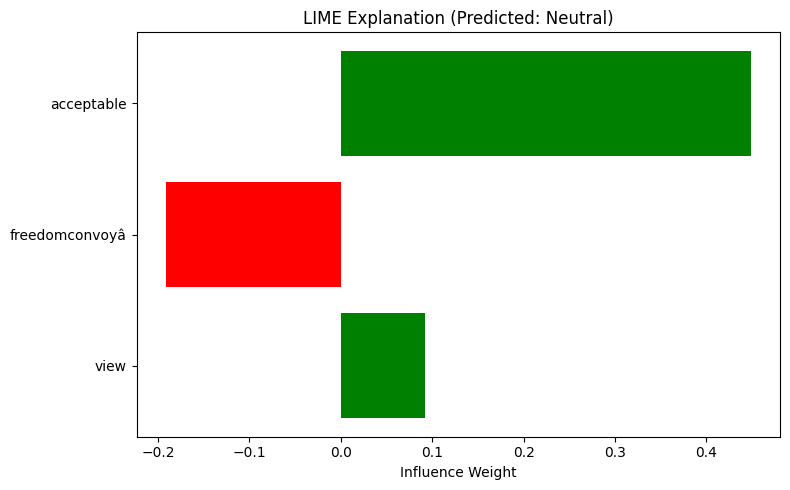

In [17]:
# Plotting local influential words using matplotlib
def plot_local_influential_words(exp, title=None):
    words, weights = zip(*exp.as_list())
    colors = ['green' if w > 0 else 'red' for w in weights]

    plt.figure(figsize=(8, 5))
    plt.barh(words, weights, color=colors)
    plt.xlabel("Influence Weight")
    plt.title(title or "LIME - Local Influential Words")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Example: Visualize tweet 5
text_id = 5
text_instance = texts[text_id]
exp = explainer.explain_instance(text_instance, predict_proba, num_features=10)
pred_class = np.argmax(predict_proba([text_instance])[0])
plot_local_influential_words(exp, title=f"LIME Explanation (Predicted: {class_names[pred_class]})")

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


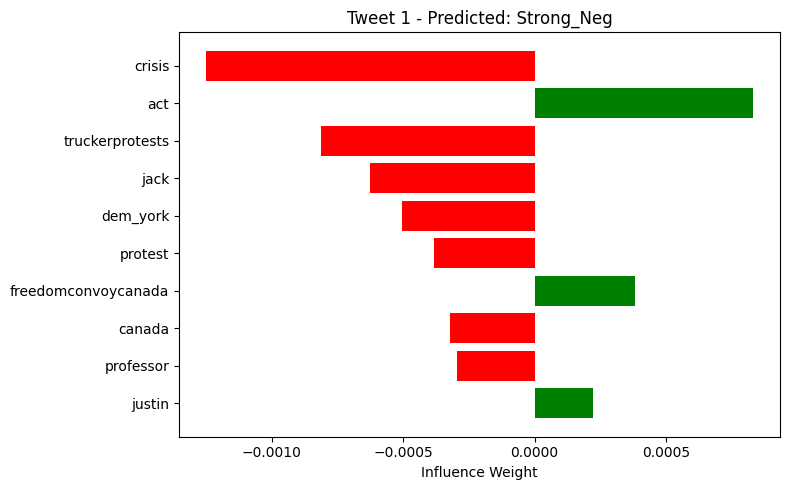

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


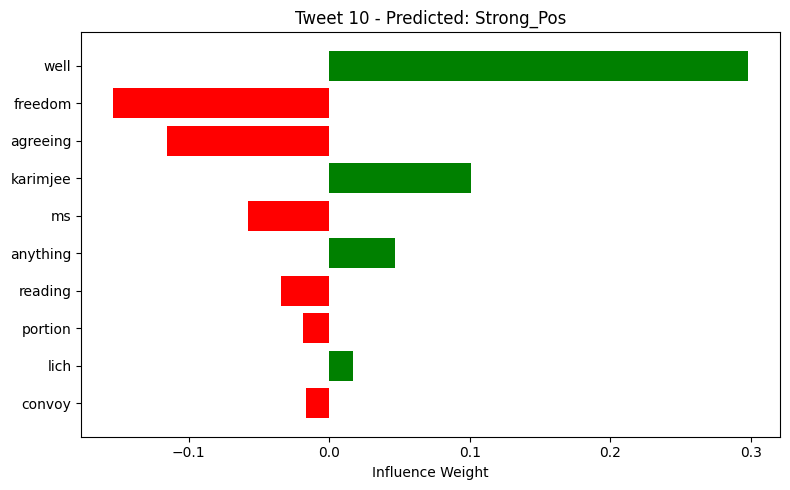

157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


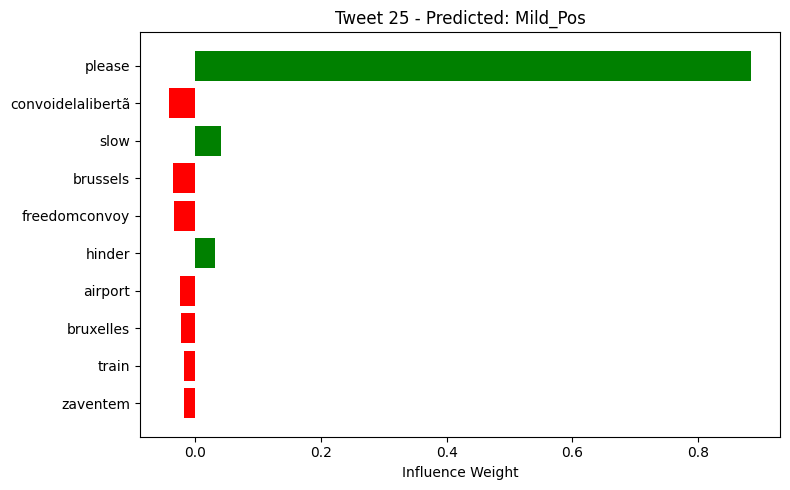

In [18]:
for text_id in [1, 10, 25]:
    text_instance = texts[text_id]
    exp = explainer.explain_instance(text_instance, predict_proba, num_features=10)
    pred_class = np.argmax(predict_proba([text_instance])[0])
    plot_local_influential_words(exp, title=f"Tweet {text_id} - Predicted: {class_names[pred_class]}")

#### Image 1: LIME Explanation (Predicted: Neutral)
- Most influential word: acceptable (strong positive)

- Negative influencer: freedomconvoyã

- Slight positive: view

- **Interpretation:** While “acceptable” is positive and “view” is slightly positive, the word “freedomconvoyã” pulls in a negative direction, balancing out to a neutral overall prediction.

#### Image 2: Tweet 1 - Predicted: Strong_Neg
- Most influential negative word: crisis

- Strong negative association, as expected.

- other negatives: truckerprotests, jack, dem_york, protest, freedomconvoycanada, canada, professor

- Positive influencers: act, freedomconvoycanada, justin

- A few words have slight positive weights but not enough to counter the negatives.

- **Interpretation:** Crisis-centric and protest-related vocabulary dominate, making the overall sentiment strongly negative, even if some words have minor positive influence.

#### Image 3: Tweet 10 - Predicted: Strong_Pos
- Most influential word: well (strong positive)

- Other positive contributors: karimjee, anything, lich

- These likely add to a constructive or agreeable tone.

- Negative influencers: freedom, agreeing, ms, reading, portion, convoy

- Some context words commonly associated with negative/controversial topics, but their effect is less than the positive words.

- **Interpretation:** Positive conversational tone words (“well”, “karimjee”) outweigh the negative context, leading to a strong positive sentiment.

#### Image 4: Tweet 25 - Predicted: Mild_Pos
- Most influential word: please (very strong positive influence)

- The large green bar indicates "please" heavily pushed the sentiment to positive.

- Negative influencers: convoiedelalibertá, brussels, freedomconvoy, airport, etc.

- These terms (likely protest/event related) push towards negative sentiment but are overpowered by "please".

- **Interpretation:** The presence of polite or positive language (like "please") dominates, causing the model to predict a mild positive sentiment, despite several slightly negative context words.

#### Overall Model Behavior Observed
- The model is heavily influenced by words that strongly indicate politeness, positivity, or negativity (“please”, “crisis”, “well”).

- Words associated with protests or controversial topics tend to have negative influence, except in certain contexts where positive conversational words dominate.

# Conclusion
### Global Word Influence Patterns
- The top globally influential words reveal clear sentiment trends:

- Strong positive influencers include: stop, thanks, funny, straight, acceptable, ready, please, and protect — all with average influence scores above +0.39.

- Strong negative influencers include: war and perfectly, suggesting that certain serious or emotionally charged words reliably push sentiment predictions toward negative classes.

- These words demonstrate that the model heavily weights terms reflecting:

- Politeness (e.g., please, thanks)

- Security or safety framing (e.g., protect, ready)

- Tone or humor (e.g., funny, acceptable)

### Insights from Local Interpretations
- Positive predictions were often driven by soft, conversational, or respectful language such as well, please, and karimjee, even when some protest-related terms were present.

- Negative predictions were strongly linked to context-heavy words like crisis, protest, and freedomconvoycanada, showing that the model recognizes socio-political tension vocabulary.

- Interestingly, some protest-related terms like freedom and convoy appeared in both negative and slightly positive roles, indicating that their sentiment effect is context-dependent.

- In one neutral prediction, the model balanced strong positives (like acceptable) against protest-related negatives (e.g., freedomconvoyã), showing LIME's value in explaining subtle model behavior.

## Overall Observations
- The model is highly sensitive to emotionally loaded or tonal language, especially words related to politeness, urgency, and social issues.

- Words with strong general sentiment (e.g., please, war) tend to dominate predictions more than niche or topic-specific terms.

- LIME provides meaningful insights for both model debugging and non-technical interpretability, helping explain why a tweet is classified a certain way—even when the overall language is mixed or ambiguous.